In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
#Load the CSV files into DataFrames

train_df = pd.read_csv('train_movie_review.csv')
val_df = pd.read_csv('val_movie_review.csv')
test_df = pd.read_csv('test_movie_review.csv')

In [ ]:
# Drop unnecessary index columns
for df in [train_df, val_df, test_df]:
    if 'Unnamed: 0' in df.columns:
        df.drop('Unnamed: 0', axis=1, inplace=True)


In [ ]:
# Preprocess text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

contraction_mapping = {
    "don't": "do not",
    "can't": "cannot",
    "i'm": "i am",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "that's": "that is",
    "what's": "what is",
    "there's": "there is",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'t": " not",
    "'ve": " have",
    "'m": " am"
}

def expand_contractions(text):
    for contraction, expanded in contraction_mapping.items():
        text = re.sub(contraction, expanded, text)
    return text

def clean_text(text):
    text = text.lower()
    text = expand_contractions(text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#\w+", '', text)
    text = re.sub(r"\d+", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

train_df['cleaned_review'] = train_df['review'].apply(clean_text)
val_df['cleaned_review'] = val_df['review'].apply(clean_text)
test_df['cleaned_review'] = test_df['review'].apply(clean_text)


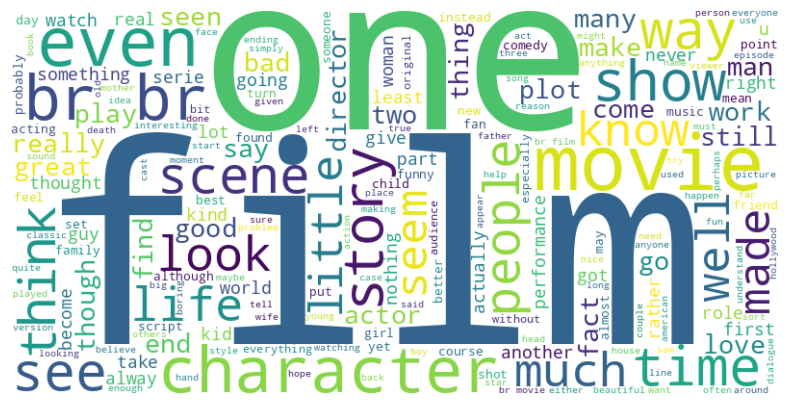

In [ ]:
# Visualize Word Cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = ' '.join(train_df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Tokenization and Padding
X_train = train_df['cleaned_review']
y_train = train_df['sentiment']
X_val = val_df['cleaned_review']
y_val = val_df['sentiment']
X_test = test_df['cleaned_review']
y_test = test_df['sentiment']

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

maxlen = int(np.percentile([len(seq) for seq in X_train_seq], 95))
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense

vocab_size = 10000
embedding_dim = 64

In [ ]:
# Model 1: Simple RNN
model1 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlen),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Model 2: LSTM
model2 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlen),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Model 3: LSTM + Word2Vec
from tensorflow.keras.initializers import Constant
X_train_tokens = [text.split() for text in X_train]

# Create a dummy Word2Vec-like embedding matrix
embedding_matrix = np.random.normal(size=(vocab_size, embedding_dim))

model3 = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=maxlen, embeddings_initializer=Constant(embedding_matrix), trainable=False),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

models = [model1, model2, model3]
histories = []

for i, model in enumerate(models):
    print(f"\nTraining Model {i+1}...")
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    history = model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_val_pad, y_val), callbacks=[es], verbose=1)
    histories.append(history)

    # Evaluation
    y_pred = (model.predict(X_test_pad) > 0.5).astype(int)
    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))



Training Model 1...
Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.5102 - loss: 0.6936 - val_accuracy: 0.5206 - val_loss: 0.6932
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - accuracy: 0.5257 - loss: 0.6887 - val_accuracy: 0.5042 - val_loss: 0.6945
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.5185 - loss: 0.6861 - val_accuracy: 0.5040 - val_loss: 0.7030
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

Accuracy: 0.5252
Confusion Matrix:
 [[1991 2970]
 [1778 3261]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.40      0.46      4961
           1       0.52      0.65      0.58      5039

    accuracy                           0.53     10000
   macro avg       0.53      0.52      0.52     10000
weighted avg       0.53      0.53      0.52     10000


Training Model 2...
Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.9589 - loss: 0.1301 - val_accuracy: 

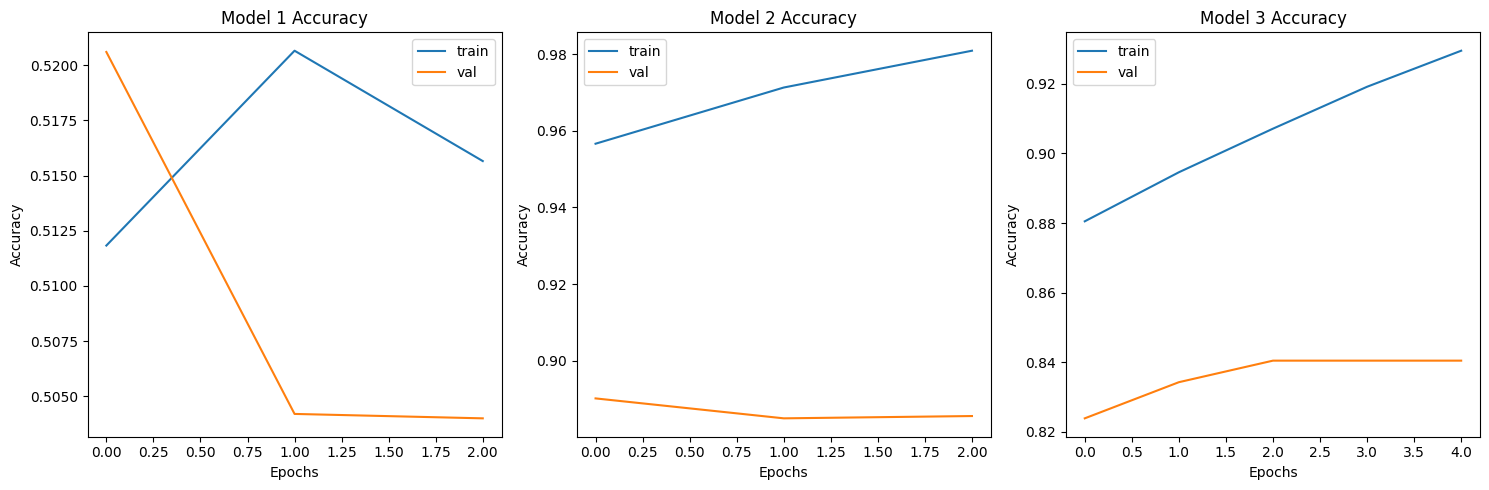

In [ ]:
# Visualization
plt.figure(figsize=(15, 5))
for i, history in enumerate(histories):
    plt.subplot(1, 3, i+1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'Model {i+1} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
plt.tight_layout()
plt.show()